In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

from statsmodels.tsa.arima.model import ARIMA

file_path = '../../data/raw/greenhouse_gas_inventory_data_completed.csv'
df = pd.read_csv(file_path)


In [150]:
df.head()

,country_or_area,continent,year,value,category
0,Australia,Oceania,2014,393126.9470,CO2 Emissions
1,Australia,Oceania,2013,396913.9365,CO2 Emissions
2,Australia,Oceania,2012,406462.8477,CO2 Emissions
3,Australia,Oceania,2011,403705.5283,CO2 Emissions
4,Australia,Oceania,2010,406200.9932,CO2 Emissions


In [151]:
# Chuyển đổi cột 'year' thành datetime, gán giá trị ngày mặc định (1/1)
df['year'] = pd.to_datetime(df['year'], format='%Y')

# Sắp xếp dữ liệu theo thời gian (year)
df = df.sort_values(by='year')

# Kiểm tra lại sau khi chuyển đổi và sắp xếp
df.head()


,country_or_area,continent,year,value,category
8405,United States of America,North America,1990-01-01,293.205663,Mixed HFCs and PFCs Emissions
2172,Canada,North America,1990-01-01,612866.051500,GHG Emissions (Excl. LULUCF)
5045,Switzerland,Europe,1990-01-01,6086.294429,CH4 Emissions
3021,Turkey,Europe/Asia,1990-01-01,207773.321100,GHG Emissions (Excl. LULUCF)
224,Czech Republic,Europe,1990-01-01,161662.018900,CO2 Emissions


In [152]:
# Lọc dữ liệu theo yêu cầu ban đầu (quốc gia Germany và CO2 Emissions)
filtered_data = df[(df['country_or_area'] == 'Germany') & (df['category'] == 'CO2 Emissions')]

# Lấy giá trị khí thải CO2 theo năm để dùng cho Auto ARIMA
co2_values = filtered_data[['year', 'value']].set_index('year')


In [153]:
filtered_data.head()

,country_or_area,continent,year,value,category
374,Germany,Europe,1990-01-01,1.052238e+06,CO2 Emissions
373,Germany,Europe,1991-01-01,1.014120e+06,CO2 Emissions
372,Germany,Europe,1992-01-01,9.657908e+05,CO2 Emissions
371,Germany,Europe,1993-01-01,9.559776e+05,CO2 Emissions
370,Germany,Europe,1994-01-01,9.392073e+05,CO2 Emissions


In [154]:
co2_values.head()

,value
year,
1990-01-01,1.052238e+06
1991-01-01,1.014120e+06
1992-01-01,9.657908e+05
1993-01-01,9.559776e+05
1994-01-01,9.392073e+05


In [155]:
# Loại bỏ các cột không cần thiết
ger_co2_values = filtered_data[['year', 'value']].set_index('year')

# Kiểm tra lại dữ liệu sau khi loại bỏ
ger_co2_values.head()


,value
year,
1990-01-01,1.052238e+06
1991-01-01,1.014120e+06
1992-01-01,9.657908e+05
1993-01-01,9.559776e+05
1994-01-01,9.392073e+05


Step 0: Explore the dataset

<Axes: xlabel='year'>

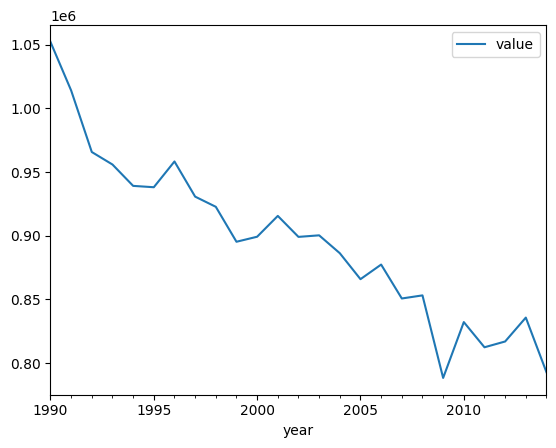

In [156]:
ger_co2_values.plot()

<Axes: xlabel='year'>

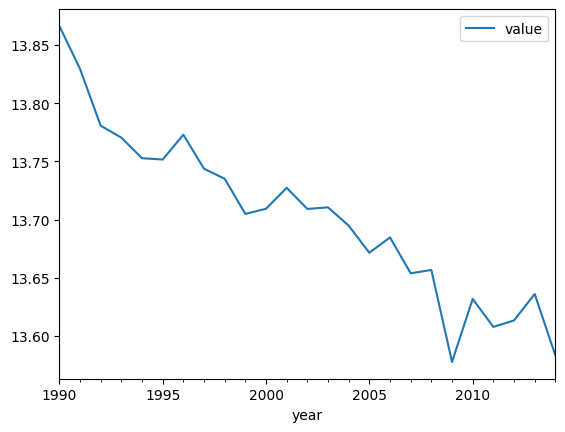

In [157]:
ger_co2_values = np.log(ger_co2_values) # don't forget to transform the data back when making real predictions
ger_co2_values.plot()

In [158]:

# Use integer-based slicing to split the data into train and test sets
train_size = int(len(ger_co2_values) * 0.8)
train = ger_co2_values.iloc[: train_size].copy()
test = ger_co2_values.iloc[train_size:].copy()

train, test


(                value
 year                 
 1990-01-01  13.866430
 1991-01-01  13.829532
 1992-01-01  13.780703
 1993-01-01  13.770490
 1994-01-01  13.752792
 1995-01-01  13.751663
 1996-01-01  13.772988
 1997-01-01  13.743766
 1998-01-01  13.735145
 1999-01-01  13.704955
 2000-01-01  13.709355
 2001-01-01  13.727372
 2002-01-01  13.709218
 2003-01-01  13.710569
 2004-01-01  13.694861
 2005-01-01  13.671592
 2006-01-01  13.684744
 2007-01-01  13.653927
 2008-01-01  13.656784
 2009-01-01  13.577789,
                 value
 year                 
 2010-01-01  13.631899
 2011-01-01  13.607851
 2012-01-01  13.613433
 2013-01-01  13.636136
 2014-01-01  13.583456)

Step 1: Check for stationarity of time series

Method #1: time series plot

Method #2: ACF plot and PACF plot

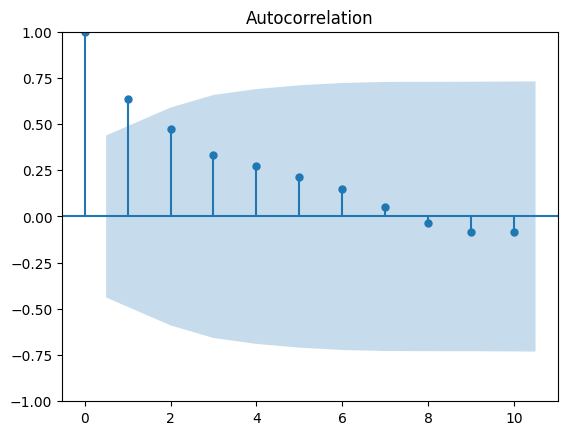

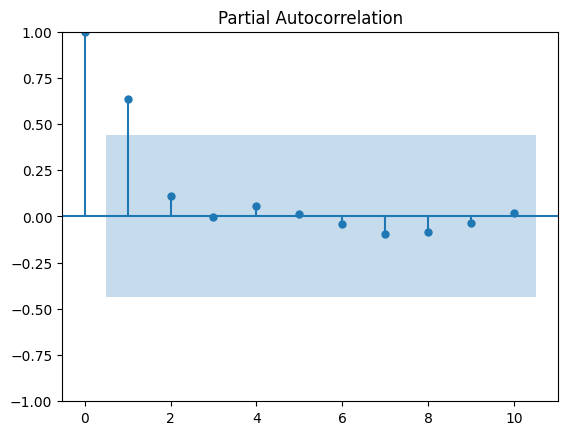

In [159]:
acf_original = plot_acf(train)

pacf_original = plot_pacf(train)

Method #3: ADF test


In [160]:
adf_test = adfuller(train)
print(f'p-value: {adf_test[1]}')

p-value: 1.0


Transform to stationary: differencing


<Axes: xlabel='year'>

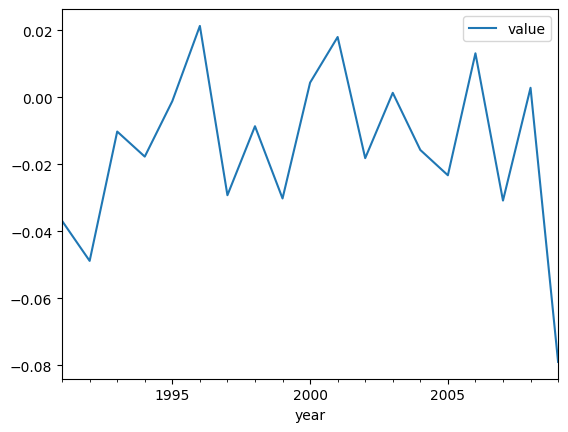

In [161]:
train_diff = train.diff().dropna()
train_diff.plot()

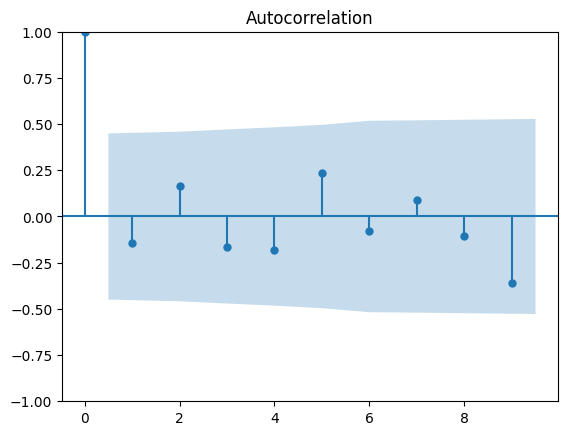

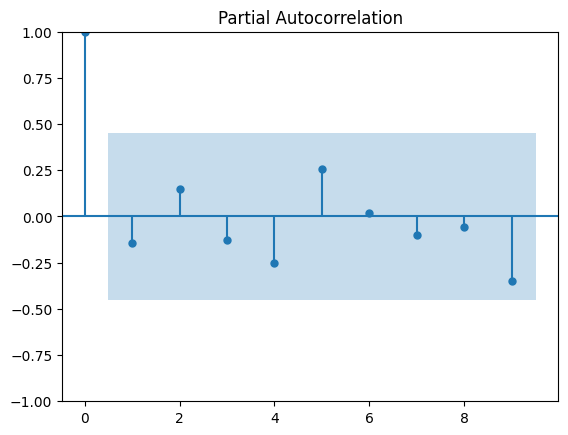

In [162]:
acf_diff = plot_acf(train_diff)

pacf_diff = plot_pacf(train_diff)

In [163]:
adf_test = adfuller(train_diff)
print(f'p-value: {adf_test[1]}')

p-value: 0.0011043438557304876


Step 2: Determine ARIMA models parameters p, q

Step 3: Fit the ARIMA model

In [164]:
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()
model_fit.summary()

c:\Users\VincentPham\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\VincentPham\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\VincentPham\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  40.726
Date:                Sun, 01 Dec 2024   AIC                            -75.451
Time:                        09:55:25   BIC                            -72.618
Sample:                    01-01-1990   HQIC                           -74.972
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3028    110.709     -0.003      0.998    -217.289     216.683
ma.L1          0.3062    110.552      0.003      0.998    -216.372     216.985
sigma2         0.0008      0.000      2.226      0.026    9.61e-05       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):                 1.91
Prob(Q):                              0.49   Prob(JB):                         0.39
Heteroskedasticity (H):               1.77   Skew:                            -0.73
Prob(H) (two-sided):                  0.50   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Step 4: Make time series predictions


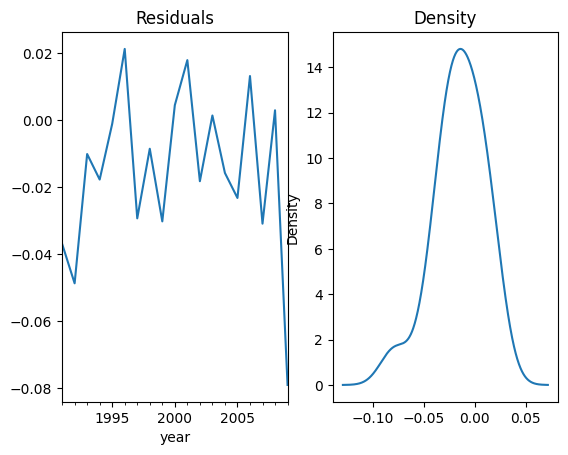

In [165]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

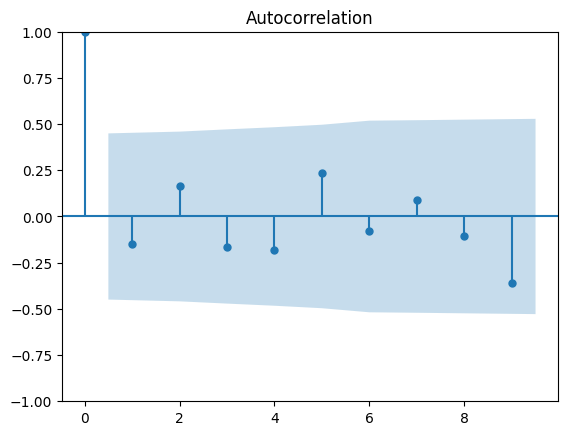

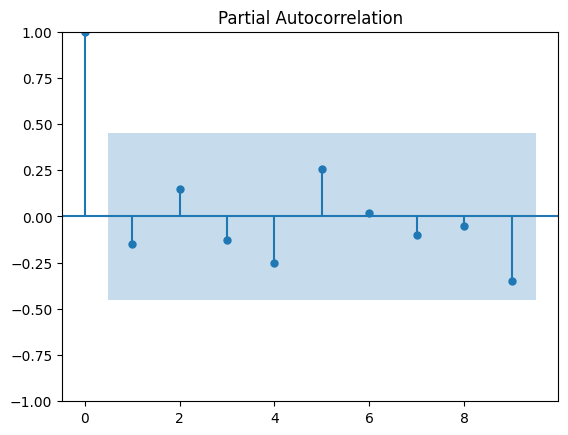

In [166]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

<Axes: xlabel='year'>

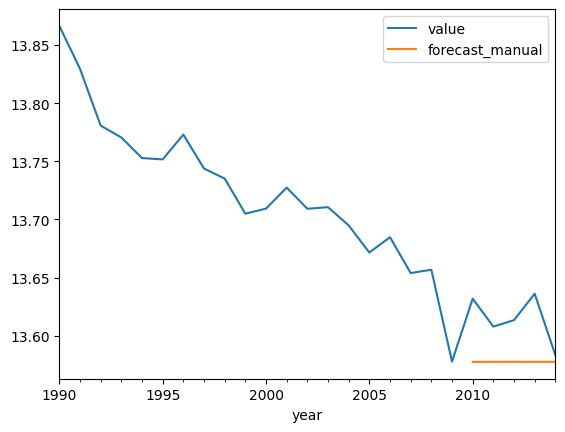

In [167]:
forecast_test = model_fit.forecast(len(test))

forecast_original = np.exp(forecast_test)

ger_co2_values['forecast_manual'] = [None]*len(train) + list(forecast_test)

ger_co2_values.plot()

Optional: Auto-fit the ARIMA model


In [168]:
import pmdarima as pm
auto_arima = pm.auto_arima(train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

In [169]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  43.935
Date:                Sun, 01 Dec 2024   AIC                            -83.870
Time:                        09:55:31   BIC                            -81.982
Sample:                    01-01-1990   HQIC                           -83.551
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0152      0.006     -2.463      0.014      -0.027      -0.003
sigma2         0.0006      0.000      3.102      0.002       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):                 1.90
Prob(Q):                              0.50   Prob(JB):                         0.39
Heteroskedasticity (H):               1.74   Skew:                            -0.72
Prob(H) (two-sided):                  0.52   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Step 5: Evaluate model predictions


<Axes: xlabel='year'>

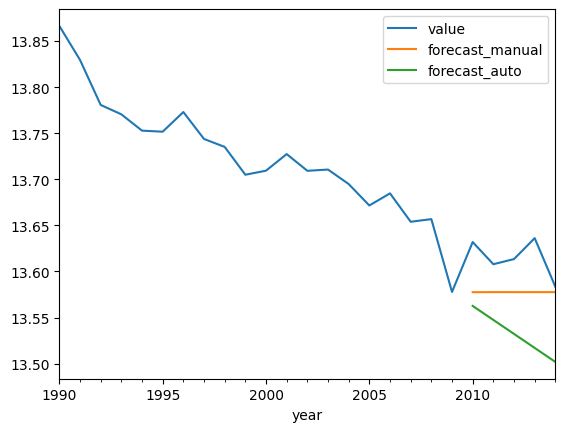

In [170]:
forecast_test_auto = auto_arima.predict(n_periods=len(test))
ger_co2_values['forecast_auto'] = [None]*len(train) + list(forecast_test_auto)

ger_co2_values.plot()

In [171]:
mse = mean_squared_error(test, forecast_test)
mae = mean_absolute_error(test, forecast_test)
mape = mean_absolute_percentage_error(test, forecast_test) * 100
rmse = np.sqrt(mean_squared_error(test, forecast_test))
r2 = r2_score(test, forecast_test)

print(f'mse - manual: {mse}')
print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')
print(f'r2 score - manual: {r2}')


mse - manual: 0.001725332213510938
mae - manual: 0.036998012130961655
mape - manual: 0.2715615879748924
rmse - manual: 0.04153711850274328
r2 score - manual: -3.8466676717300015


In [172]:
mse = mean_squared_error(test, forecast_test_auto)
mae = mean_absolute_error(test, forecast_test_auto)
mape = mean_absolute_percentage_error(test, forecast_test_auto) * 100
rmse = np.sqrt(mean_squared_error(test, forecast_test_auto))
r2 = r2_score(test, forecast_test_auto)

print(f'mse - auto: {mse}')
print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')
print(f'r2 score - auto: {r2}')

mse - auto: 0.0071806398647695615
mae - auto: 0.08234046207294554
mape - auto: 0.6047189634712254
rmse - auto: 0.08473865626011284
r2 score - auto: -19.171289229043126


In [173]:
# Giả sử forecast_test là dữ liệu dự đoán từ mô hình ARIMA trên dữ liệu log-transformed
# Chuyển đổi dữ liệu dự đoán về dạng gốc bằng cách sử dụng exp
forecast_original = np.exp(forecast_test)
test_original = np.exp(test)
forecast_auto_original = np.exp(forecast_test_auto)
test_original

,value
year,
2010-01-01,832259.2033
2011-01-01,812483.2196
2012-01-01,817031.4402
2013-01-01,835792.6323
2014-01-01,792902.7880


In [174]:
mse = mean_squared_error(test_original, forecast_original)
mae = mean_absolute_error(test_original, forecast_original)
mape = mean_absolute_percentage_error(test_original, forecast_original) * 100
rmse = np.sqrt(mean_squared_error(test_original, forecast_original))
r2 = r2_score(test_original, forecast_original)

print(f'mse - manual: {mse}')
print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')
print(f'r2 score - manual: {r2}')

mse - manual: 1127841823.411616
mae - manual: 29854.674031052717
mape - manual: 3.6149687940642647
rmse - manual: 33583.356345243636
r2 score - manual: -3.774533378926157


In [175]:
mse = mean_squared_error(test_original, forecast_auto_original)
mae = mean_absolute_error(test_original, forecast_auto_original)
mape = mean_absolute_percentage_error(test_original, forecast_auto_original) * 100
rmse = np.sqrt(mean_squared_error(test_original, forecast_auto_original))
mse = mean_squared_error(test_original, forecast_auto_original)

print(f'mse - auto: {mse}')
print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')
print(f'r2 score - auto: {r2}')

mse - auto: 4421858093.317102
mae - auto: 64623.33233252971
mape - auto: 7.885825770232101
rmse - auto: 66497.05326792385
r2 score - auto: -3.774533378926157
